Prédiction de séries temporelles à l'aide de méthodes statistiques (TP)
Data utilisées: information sur les ventes d'oignons en Inde.

Objectif: predire les ventes pour la ville de Bangalore.

Le fichier de données se trouve dans le fichier partagé.

Import des libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)


Chargement et préparation des données

In [39]:
data_path = 'monthly_market_arrivals.csv'
import os

os.getcwd()

'c:\\Users\\Aflokkat\\Documents\\AflokkatUSB\\Cours\\MasterBIHAR\\Machine Learning 2\\Marie-Lise'

In [40]:
data = pd.read_csv(data_path)

# Sort data and define index based on the date column

# data.index = pd.PeriodIndex(data.date, freq="M")
# voir pourquoi cela ne marche pas
data.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,2005-01-01
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,2006-01-01
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,2010-01-01
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,2011-01-01
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,2012-01-01


In [41]:
data['date'] = pd.to_datetime(data['date'], errors='coerce') #converti chaine en datetime, coerce pour mettre NAT au lieu de planter
data = data.sort_values('date')  # sort par la date
data.set_index('date', inplace=True)  # index date


In [42]:
data.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city
date,,,,,,,,,
1996-01-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON
1996-02-01,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON
1996-03-01,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON
1996-04-01,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON
1996-05-01,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON


Garder seulement la variable d'intérêt (quantity) pour la ville de Bangalore.

In [43]:
ts_data = data.loc[data.city == "BANGALORE", ['quantity']]
ts_data.head()

,quantity
date,
2004-01-01,227832
2004-02-01,225133
2004-03-01,221952
2004-04-01,185150
2004-05-01,137390


Afficher la série de données.

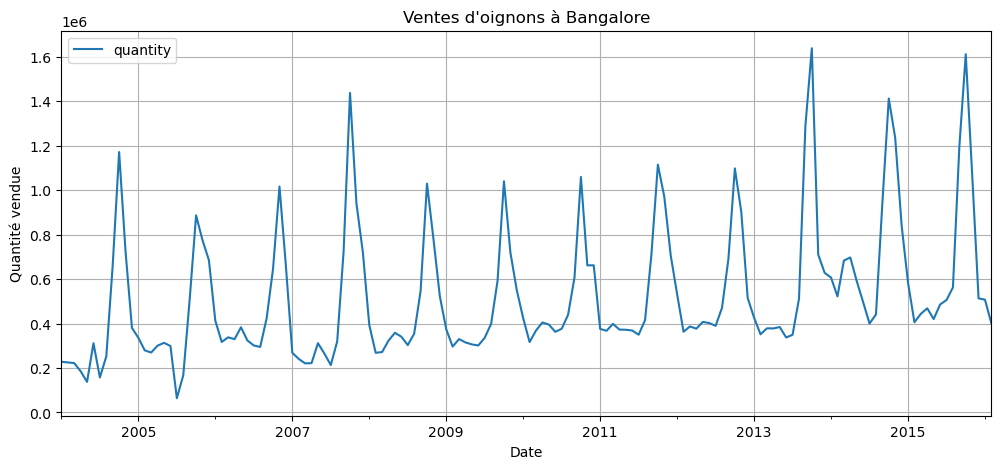

In [44]:
ts_data.plot(figsize=(12, 5))
plt.title("Ventes d'oignons à Bangalore")
plt.xlabel("Date")
plt.ylabel("Quantité vendue")
plt.grid(True)
plt.show()

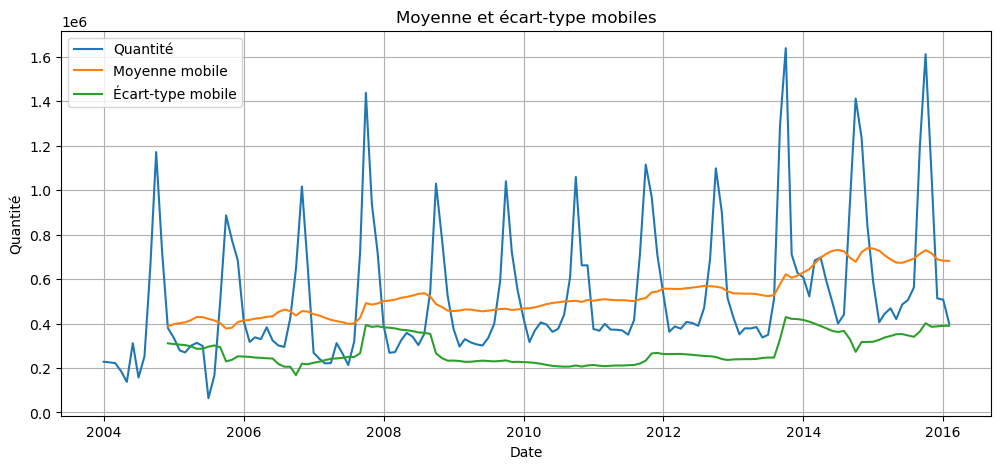

In [45]:
rolling_mean = ts_data['quantity'].rolling(window=12).mean()
rolling_std = ts_data['quantity'].rolling(window=12).std()

plt.figure(figsize=(12, 5))
plt.plot(ts_data, label='Quantité')
plt.plot(rolling_mean, label='Moyenne mobile')
plt.plot(rolling_std, label='Écart-type mobile')
plt.title("Moyenne et écart-type mobiles")
plt.xlabel("Date")
plt.ylabel("Quantité")
plt.legend()
plt.grid(True)
plt.show()


In [46]:
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(ts_diff):
    print("Test ADF")
    adf_stat, adf_pvalue, *_ = adfuller(ts_diff.dropna())
    print(f"Statistique ADF : {adf_stat}")
    print(f"p-value ADF      : {adf_pvalue}")
    if adf_pvalue < 0.05:
        print("La série est stationnaire selon ADF")
    else:
        print("La série n'est PAS stationnaire selon ADF")

    print("\nTest KPSS")
    kpss_stat, kpss_pvalue, _, _ = kpss(ts_diff.dropna(), regression='c')
    print(f"Statistique KPSS : {kpss_stat}")
    print(f"p-value KPSS     : {kpss_pvalue}")
    if kpss_pvalue < 0.05:
        print("La série n'est PAS stationnaire selon KPSS")
    else:
        print("La série est stationnaire selon KPSS")

Etape 1. Vérifier la stationnarité en utilisant le test KPSS.

Test de stationnarité KPSS: H0 = stationnarité

In [47]:
test_stationarity(ts_data)


Test ADF
Statistique ADF : -0.87800739689695
p-value ADF      : 0.7951286022098925
La série n'est PAS stationnaire selon ADF

Test KPSS
Statistique KPSS : 0.8362297823646005
p-value KPSS     : 0.01
La série n'est PAS stationnaire selon KPSS


La série est-elle stationnaire et pourquoi ? 

Observez les différences selonn les options de la fonction kpss.

Si on tient compte de la tendance la série est-elle stationnaire ?

Etape 1bis. Utilisez le test augmenté de Dickey-Fuller: 
H0: la série n'est pas stationnaire

Est-ce qu'n ne rejette H0 ? est-ce que cela signifie que la série est stationnaire ? 
Quelle est la différence entre les deux tests ? 

Si on tient compte de la tendance, la série est-elle stationnaire ?

Etape 2. Box Cox transformation
Essayez une transformation Box Cox et afficher λ.

si  λ<0 , supposons que  λ=0  et appliquons une simple transformation logarithmique.

Faire un graphe de la série transformée. Est-ce que la variance est plus homogène visuellement ?

Utilisez la série transformée dans les prochaines étapes. 

In [48]:
from scipy.stats import boxcox

quantity = ts_data['quantity'].dropna()
boxcox_results = boxcox(quantity)


In [49]:
transformed = boxcox_results[0]
fitted_lambda = boxcox_results[1]

print(f"Lambda (λ) : {fitted_lambda}")


Lambda (λ) : -0.037973894835219395


In [50]:
quantity = ts_data['quantity'].dropna()
transformed = np.log(quantity)

ts_transformed = pd.Series(transformed, index=quantity.index)


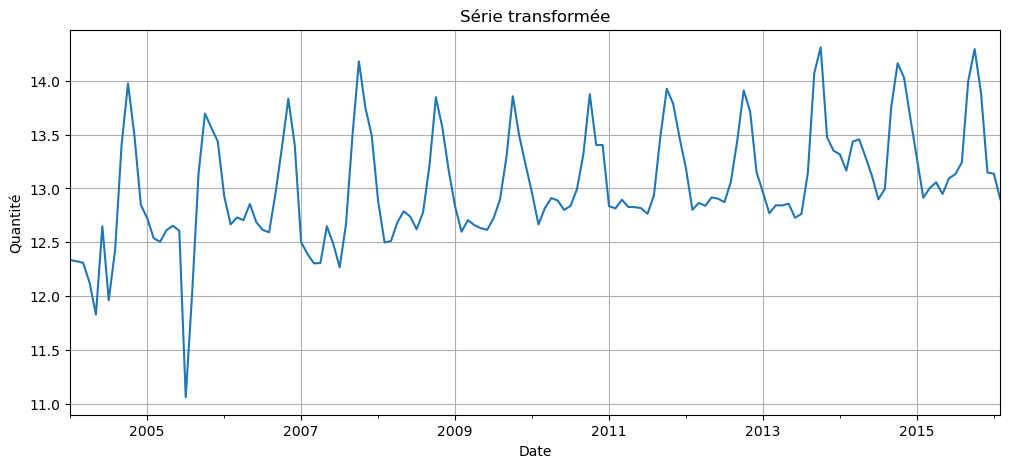

In [51]:
plt.figure(figsize=(12, 5))
ts_transformed.plot()
plt.title("Série transformée")
plt.xlabel("Date")
plt.ylabel("Quantité")
plt.grid(True)
plt.show()


Etape 3. Differenciation
S'il y a une légère tendance saisonnière dans la série, appliquez-lui une différenciation (méthode des différences). 

Est-ce que la série devient stationnaire ? 

In [52]:
ts_diff = ts_transformed.diff().dropna()


In [53]:
ts_diff.head()

date
2004-02-01   -0.011917
2004-03-01   -0.014230
2004-04-01   -0.181295
2004-05-01   -0.298343
2004-06-01    0.818399
Name: quantity, dtype: float64

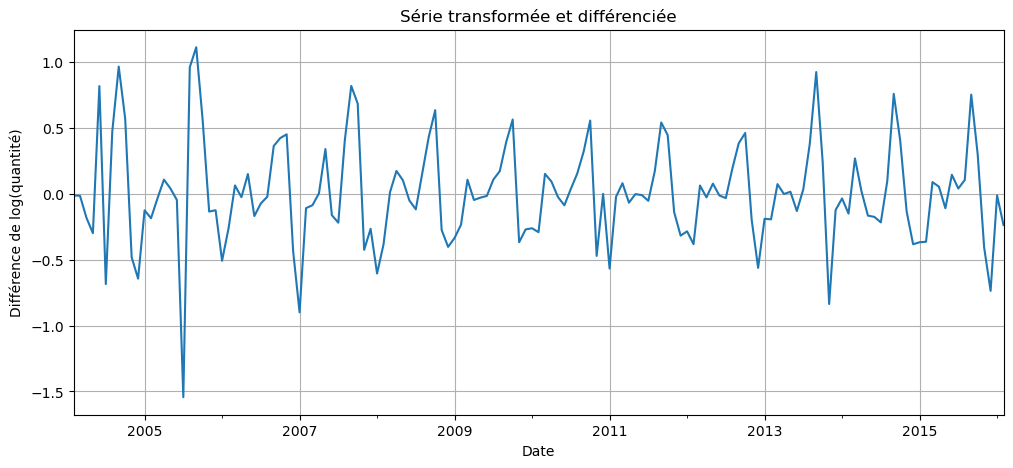

In [54]:
plt.figure(figsize=(12, 5))
ts_diff.plot()
plt.title("Série transformée et différenciée")
plt.xlabel("Date")
plt.ylabel("Différence de log(quantité)")
plt.grid(True)
plt.show()


In [55]:
test_stationarity(ts_diff)


Test ADF
Statistique ADF : -6.7294446648668815
p-value ADF      : 3.3247010834509493e-09
La série est stationnaire selon ADF

Test KPSS
Statistique KPSS : 0.07439922284285584
p-value KPSS     : 0.1
La série est stationnaire selon KPSS


La série des différences est-elle stationnaire ?

Etape 4. Identifier les hyper paramètres de la série ARIMA
Identifier  p  et  q  values pour le modèle ARIMA (SARIMAX) en utilisant les graphiques des autocorrélation et autocorrélations partielles (ACF et PACF plots).

Les fenêtres de valeurs pour ces paramètres incluent toutes les valeurs de 0 jusqu'au lag correspondant à la dernière valeur significative dans la période (le lag de la période elle-même n'est pas pris en compte).

In [56]:
print(len(ts_data))
print(len(ts_transformed))
print(len(ts_diff))


146
146
145


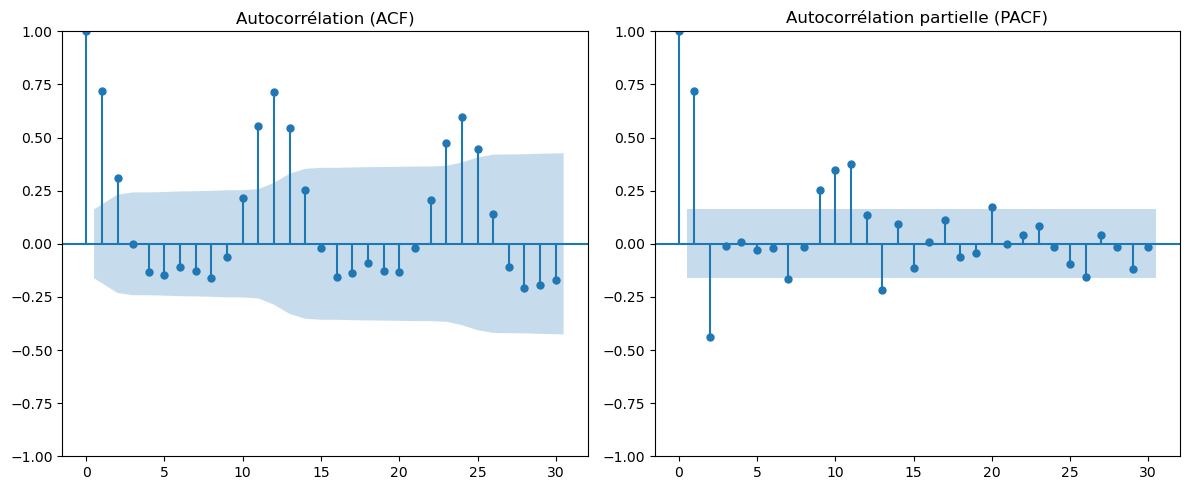

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(ts_transformed, ax=plt.gca(), lags=30)
plt.title("Autocorrélation (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(ts_transformed, ax=plt.gca(), lags=30, method='ywm')
plt.title("Autocorrélation partielle (PACF)")

plt.tight_layout()
plt.show()


Etape 5. Diviser le jeu de données en train validation et test sets.
Dans les prochaines étapes vous allez utiliser un modèle SARIMAX.
Donc vous aurez besoin d'utiliser les données initiales (non transformées par différenciation ou Box Cox, etc.).

train - les premiers 65% des données
val - les 20% suivants
test - les derniers 15% 
Vérifier la forme de chaque set et les afficher sur le même graphique

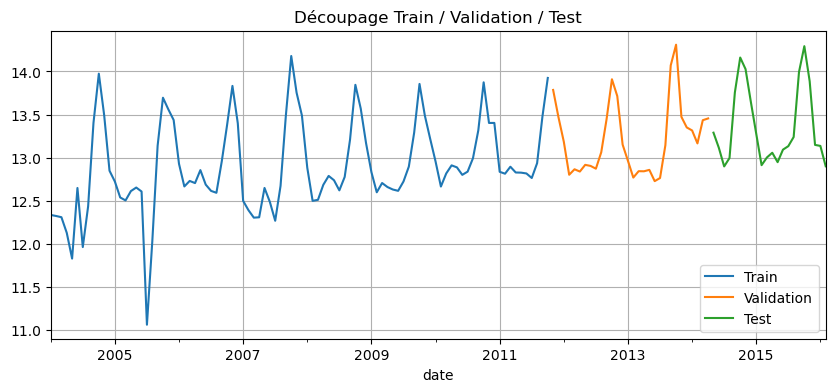

Formes :
Train : (94,)
Validation : (30,)
Test : (22,)


In [58]:
ts = ts_transformed.dropna()
n = len(ts)

i65, i85 = int(n * 0.65), int(n * 0.85)

train = ts.iloc[:i65]
val   = ts.iloc[i65:i85]
test  = ts.iloc[i85:]

# Affichage graphique
plt.figure(figsize=(10, 4))
train.plot(label='Train')
val.plot(label='Validation')
test.plot(label='Test')
plt.legend()
plt.title("Découpage Train / Validation / Test")
plt.grid(True)
plt.show()

# Affichage des tailles
print("Formes :")
print(f"Train : {train.shape}")
print(f"Validation : {val.shape}")
print(f"Test : {test.shape}")


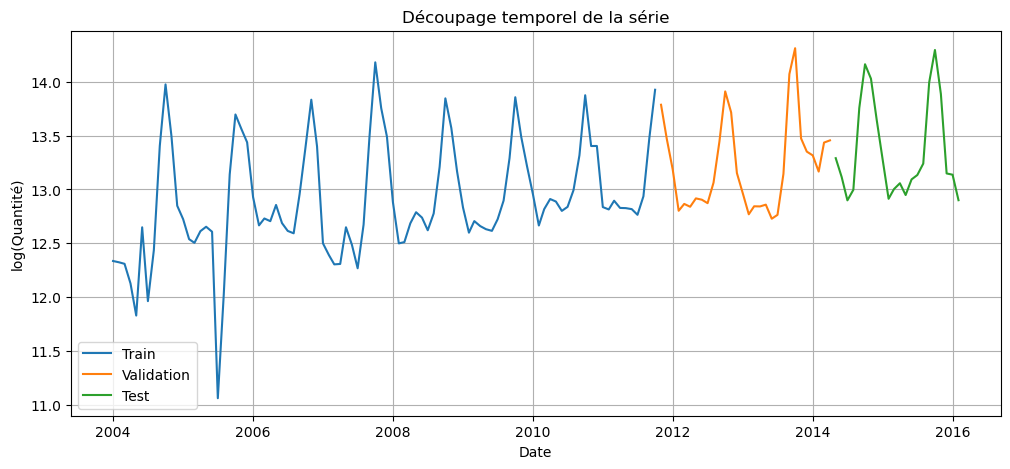

In [59]:
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train')
plt.plot(val, label='Validation')
plt.plot(test, label='Test')
plt.title("Découpage temporel de la série")
plt.xlabel("Date")
plt.ylabel("log(Quantité)")
plt.legend()
plt.grid(True)
plt.show()

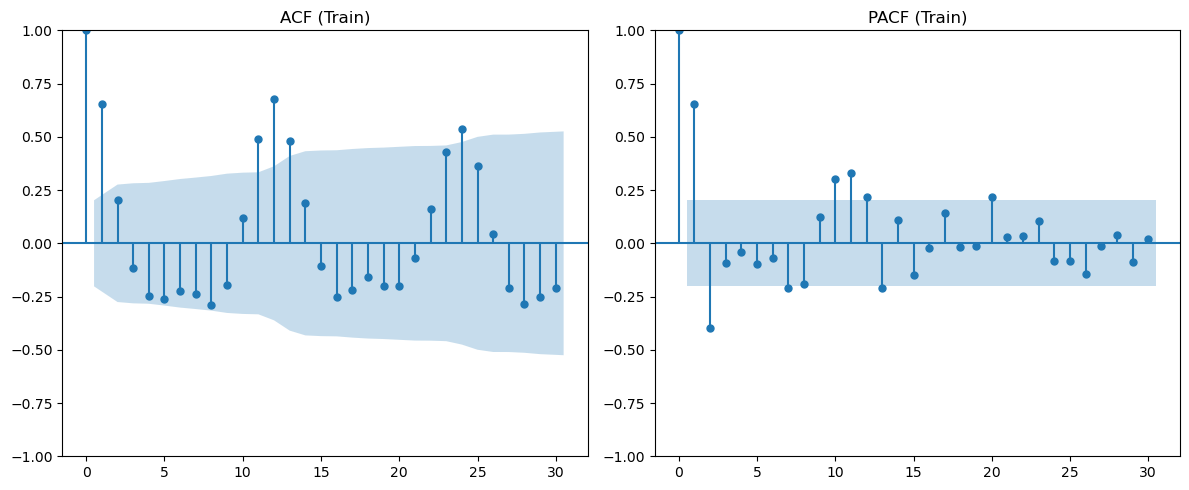

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(train, ax=plt.gca(), lags=30)
plt.title("ACF (Train)")

plt.subplot(1, 2, 2)
plot_pacf(train, ax=plt.gca(), lags=30, method='ywm')
plt.title("PACF (Train)")

plt.tight_layout()
plt.show()


In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARIMA simple sans saisonnalité
model = SARIMAX(train,
                order=(3, 1, 2),  
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(f"AIC ARIMA : {results.aic}")


AIC ARIMA : 76.54941694180901


In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q, s= 3, 0, 2, 12

model = SARIMAX(train,
                order=(p, d, q),
                seasonal_order=(1, 1, 1, s),
                enforce_stationarity=False,
                enforce_invertibility=False
                )

results = model.fit()

print(f"AIC : {results.aic}")


AIC : 0.34284982574894585


In [69]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def evaluate_arima(params, ts_train, ts_val):
    p, d, q = params
    try:
        model = ARIMA(ts_train, order=(p, d, q))
        results = model.fit()
        forecast = results.predict(start=ts_val.index[0], end=ts_val.index[-1])
        mse = mean_squared_error(ts_val, forecast)
        rmse = np.sqrt(mse)
        return results.aic, rmse
    except Exception as e:
        print(f"Erreur ARIMA pour (p,d,q)=({p},{d},{q}) : {e}")
        return np.inf, np.inf


In [73]:
from sklearn.metrics import mean_squared_error


def evaluate_sarimax(params, paramsSeason, ts_train, ts_val):
    p, d, q = params
    P, D, Q = paramsSeason
    s = 12
    try:
        model = SARIMAX(ts_train,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False
                        )
        results = model.fit(disp=False)
        forecast = results.predict(start=ts_val.index[0], end=ts_val.index[-1])
        mse = mean_squared_error(ts_val, forecast)
        rmse = np.sqrt(mse)
        return results.aic, rmse

    except Exception as e:
        print(f"Erreur pour (p,d,q)=({p},{d},{q}) : {e}")
        return np.inf, np.inf


In [74]:
from tqdm import tqdm

best_aic = np.inf
best_rmse = np.inf
best_params = None

param_grid = [(p, d, q) for p in range(1, 13) for d in [0, 1] for q in range(1, 13)]

for (p, d, q) in tqdm(param_grid, desc="Recherche des meilleurs paramètres"):
    aic, rmse = evaluate_arima((p, d, q), train, val)
    if aic < best_aic:
        best_aic = aic
        best_rmse = rmse
        best_params = (p, d, q)

print("\nMeilleur modèle selon AIC")
print(f"(p,d,q) = {best_params}")
print(f"AIC = {best_aic:.3f}")
print(f"RMSE = {best_rmse:.3f}")

Recherche des meilleurs paramètres:   0%|          | 0/288 [00:00<?, ?it/s]

Recherche des meilleurs paramètres: 100%|██████████| 288/288 [03:30<00:00,  1.37it/s]


Meilleur modèle selon AIC
(p,d,q) = (11, 1, 3)
AIC = 38.505
RMSE = 0.268


In [ ]:
from tqdm import tqdm

fixed_order = best_params
best_aic = np.inf
best_rmse = np.inf
best_seasonal_params = None

seasonal_grid = [(P, D, Q) for P in range(1, 13) for D in [0, 1] for Q in range(1, 13)]
s = 12

for (P, D, Q) in tqdm(seasonal_grid, desc="Recherche des meilleurs paramètres saisonniers"):
    try:
        aic, rmse = evaluate_sarimax(best_params, (P, D, Q), train, val)
        if aic < best_aic:
            best_aic = aic
            best_rmse = rmse
            best_seasonal_params = (P, D, Q)

    except Exception as e:
        continue

print("\nMeilleur modèle SARIMAX global")
print(f"order = {fixed_order}")
print(f"seasonal_order = {best_seasonal_params}")
print(f"AIC = {best_aic:.3f}")
print(f"RMSE = {best_rmse:.3f}")


Recherche des meilleurs paramètres saisonniers:  43%|████▎     | 125/288 [28:07<1:21:33, 30.02s/it]

In [67]:
print(seasonal_grid)

[(1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 0, 5), (1, 0, 6), (1, 0, 7), (1, 0, 8), (1, 0, 9), (1, 0, 10), (1, 0, 11), (1, 0, 12), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 1, 6), (1, 1, 7), (1, 1, 8), (1, 1, 9), (1, 1, 10), (1, 1, 11), (1, 1, 12), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 0, 5), (2, 0, 6), (2, 0, 7), (2, 0, 8), (2, 0, 9), (2, 0, 10), (2, 0, 11), (2, 0, 12), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 1, 5), (2, 1, 6), (2, 1, 7), (2, 1, 8), (2, 1, 9), (2, 1, 10), (2, 1, 11), (2, 1, 12), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (3, 0, 5), (3, 0, 6), (3, 0, 7), (3, 0, 8), (3, 0, 9), (3, 0, 10), (3, 0, 11), (3, 0, 12), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (3, 1, 5), (3, 1, 6), (3, 1, 7), (3, 1, 8), (3, 1, 9), (3, 1, 10), (3, 1, 11), (3, 1, 12), (4, 0, 1), (4, 0, 2), (4, 0, 3), (4, 0, 4), (4, 0, 5), (4, 0, 6), (4, 0, 7), (4, 0, 8), (4, 0, 9), (4, 0, 10), (4, 0, 11), (4, 0, 12), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4), (4, 1, 5),

Etape 6. Ajuster les hyperparamètres ARIMA du modèle SARIMAX.
Dans l'étape 4, vous avez identifié les ranges pour p  et  q. 
Dans l'étape 3, vous avez vu qu'une différence d'un seul temps (d=1) transformait la série en une série staionnaire. 
d=0  peut aussi etre considéré. 

Pour ajuster les hyperparamètres  (p,d,q), vous allez utiliser le modèle SARIMAX et le critère AIC. 
En utilisant des boucles imbriquées, trouver les valeurs de (p,d,q)  correspondant à l'AIC minimum.

Vérifier le résultat:  (p,d,q)=(11,1,3)  et  AIC=38.390 .

Essayez d'utiliser le RMSE pour ajuster  (p,d,q).

In [ ]:

def evaluate_sarimax(params, ts_train, ts_val):
 

_IncompleteInputError: incomplete input (1644879911.py, line 2)

In [ ]:
import 

p_params = range(0,11)
q_params = range(0,11)
d_params = [0,1]

# hyperparameters combinations


    # Use all the available cores
    
# Find the best hyperparameters


Essayer d=2

In [ ]:
p_params = range(0,11)
q_params = range(0,11)
# Try d=2
d_params = [2]


In [ ]:
best_params, best_score = 
print(f"\nMeilleurs paramètres pour minimiser le RMSE (d=1 or 2): {best_params}, score: {best_score}")
best_params, best_score = 
print(f"Meilleurs paramètres pour minimiser le RMSE  (d=3): {best_params}, score: {best_score}")

In [ ]:
best_params, best_score = 
print(f"\nMeilleurs paramètres pour maximiser le R2 (d=1 or 2): {best_params}, score: {best_score}")
best_params, best_score = 
print(f"Meilleurs paramètres pour maximiser le R2 (d=3): {best_params}, score: {best_score}")

Etape 7. Faire des prédictions

Ajuster un modèle SARIMAX sur les jeux train et val en utilisant les meilleures valeurs des paramètres (p,d,q) trouvées à l'étape précédente.
Ensuite, générer des prédictions sur le jeu test.

Afficher les données train et val ensemble, les données test et les prédictions pour la période de test.

Calculer le RMSE sur les données test et affichez le en titre du graphique.

Etape 8. Tuning des paramètres saisonniers du modèle SARIMAX

En utilisant la fonction d'auto corrélation (ACF) et l'auto corrélation partielle (PACF), détecter les ranges de valeurs appropriés pour P et Q. 
Inclure 0.
Déterminer s.

Trouver la meilleure combinaison (P,D,Q):

Utiliser un modèle SARIMAX et le critète AIC.
Utiliser (p,d,q) trouvés à l'étape 6.
Essayer D=0 et D=1.

In [ ]:
import  as 



Valeurs possibles pour Q : 0, 1, 2, 3, correspondant aux décalages (lags) 0, 12, 24, and 36.

Valeurs possibles pour  for P : 0 and 1, correspondant aux décalages (lags) 0 and 12.

In [ ]:
P_params = [0, 1]
Q_params = [0, 1, 2, 3]
D_params = [0, 1]
s = 12

Etape 9. Effectuer des prédictions

Ajuster un modèle SARIMAX sur le jeu train + val en utilisant les meilleures valeurs de (p,d,q) et de (P,D,Q,s) trouvés à l'étape précédente. Faire des prévisions sur le jeu test.

Afficher la série d'entraînement (train + val) et la série test avec les prédictions pour cette série. 

Calculer le RMSE sur les données test. Afficher le en titre.

Est-ce que le modèle SARIMAX basé sur le modèle ARIMA ajusté et les paramètres saisonniers font de bonnes prédictions ?

Etape 10. Amélioration du modèle

Essayez des paramètres exogènes (ou variables explicatives) tels que priceMod (paramètre exog de la fonction SARIMAX).

In [ ]:
from sklearn.preprocessing import MinMaxScaler



Analyse des résidus.
Les résidus d'un modèle sont la différence entre les valeurs prédites et les vraies valeurs observées.

Un bon modèle a des residus similaires à un bruit blanc et doivent être distribués normalement de moyenne nulle et non-corréles.

Quantile-quantile (Q-Q) plot
Analyse Qualitative : la distribution des résidus est-elle normale ?

In [ ]:

residuals = 

La distribution des résidus est proche d'une distribution normale.

Test de Ljung-Box.

Analysis quantitative : est-ce que les résidus sont décorrélés (entre eux) ?

Le test de Ljung-Box est un test statistique qui détermine si l'autocorrelation d'une série de données est significantivement différente de 0.

L'hypothèse nulle: les données sont indépendamment distribuées (pas d'autocorrelation)

Si la  p_value>0.05 , on ne peut pas rejeter l'hypothèse nulle : les residus sont indépendamment distribués et le modèle peut être utilisé pour la prédiction.

Sinon, le modèle est mauvais et ne devrait pas être utilisé.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox


Les résidus ne sont pas autocorrélés donc on peut utiliser le modèle pour faire des prédictions.